# Credit Risk Analysis

This notebook reproduces the exam tasks using pandas and matplotlib. Run cells sequentially.

In [ ]:
# Load libraries and data
import os
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

pd.options.display.float_format = '{:,.2f}'.format
xlsx_path = "D:/PY Projects/Credit-Risk/Credit_Risk_Dataset.xlsx"
try:
    df = pd.read_excel(xlsx_path, sheet_name=0)
    print('Loaded dataset with', len(df), 'rows and', len(df.columns), 'columns.')
except Exception as e:
    print('Error loading dataset:', e)
    df = None


Loaded dataset with 32581 rows and 29 columns.


In [43]:
# Inspect dataset
if df is not None:
    display(df.head())
    print('Columns:', df.columns.tolist())
    print('\nMissing values:')
    print(df.isnull().sum())
else:
    print('Dataset not loaded.')

,client_ID,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,...,city_latitude,city_longitude,employment_type,loan_term_months,loan_to_income_ratio,other_debt,debt_to_income_ratio,open_accounts,credit_utilization_ratio,past_delinquencies
0,CUST_00001,22,59000,RENT,123.00,PERSONAL,D,35000,16.02,1,...,43.65,-79.38,Self-employed,36,0.59,"8,402.45",0.74,14,0.50,0
1,CUST_00002,21,9600,OWN,5.00,EDUCATION,B,1000,11.14,0,...,43.65,-79.38,Full-time,36,0.10,"1,607.80",0.27,10,0.59,3
2,CUST_00003,25,9600,MORTGAGE,1.00,MEDICAL,C,5500,12.87,1,...,51.62,-3.94,Full-time,36,0.57,"2,760.51",0.86,14,0.75,0
3,CUST_00004,23,65500,RENT,4.00,MEDICAL,C,35000,15.23,1,...,49.28,-123.12,Part-time,12,0.53,"7,155.29",0.64,15,0.38,0
4,CUST_00005,24,54400,RENT,8.00,MEDICAL,C,35000,14.27,1,...,42.89,-78.88,Part-time,36,0.64,"15,626.15",0.93,4,0.23,0


Columns: ['client_ID', 'person_age', 'person_income', 'person_home_ownership', 'person_emp_length', 'loan_intent', 'loan_grade', 'loan_amnt', 'loan_int_rate', 'loan_status', 'loan_percent_income', 'cb_person_default_on_file', 'cb_person_cred_hist_length', 'gender', 'marital_status', 'education_level', 'country', 'state', 'city', 'city_latitude', 'city_longitude', 'employment_type', 'loan_term_months', 'loan_to_income_ratio', 'other_debt', 'debt_to_income_ratio', 'open_accounts', 'credit_utilization_ratio', 'past_delinquencies']

Missing values:
client_ID                        0
person_age                       0
person_income                    0
person_home_ownership            0
person_emp_length              895
loan_intent                      0
loan_grade                       0
loan_amnt                        0
loan_int_rate                 3116
loan_status                      0
loan_percent_income              0
cb_person_default_on_file        0
cb_person_cred_hist_length   

## Section A — Data Preparation (remove duplicates, fill nulls, split ownership, calculated column, format numbers)

In [44]:
# Data preparation steps
df_prep = df.copy() if df is not None else None
if df_prep is not None:
    if 'client_ID' in df_prep.columns:
        df_prep = df_prep.drop_duplicates(subset=['client_ID'])
    if 'person_income' in df_prep.columns:
        df_prep['person_income'] = df_prep['person_income'].fillna(df_prep['person_income'].mean())
    if 'person_home_ownership' in df_prep.columns:
        def split_ownership(val):
            if pd.isna(val): return (np.nan,np.nan)
            for sep in ['/', '-', ';', '|']:
                if sep in str(val):
                    parts = [p.strip() for p in str(val).split(sep) if p.strip()!='']
                    if len(parts)>=2: return (parts[0].upper(), parts[1])
            token = str(val).strip().split()[0].upper()
            remainder = str(val)[len(token):].strip() or np.nan
            return (token, remainder)
        df_prep[['Ownership_Status','Ownership_Type']] = df_prep['person_home_ownership'].apply(lambda x: pd.Series(split_ownership(x)))
    if 'debt_to_income_ratio' in df_prep.columns:
        df_prep['Debt_to_Income_Check'] = df_prep['debt_to_income_ratio'].apply(lambda x: 'High Risk' if pd.notnull(x) and x>0.5 else 'Low Risk')
    for col in ['person_income','loan_amnt','loan_int_rate']:
        if col in df_prep.columns:
            df_prep[col] = pd.to_numeric(df_prep[col], errors='coerce')
    df_prep.to_csv('D:/PY Projects/Credit-Risk/credit_risk_prepared.csv', index=False)
    print('Prepared dataset saved to D:/PY Projects/Credit-Risk/credit_risk_prepared.csv')
    display(df_prep.head())
else:
    print('No prepared dataframe.')

Prepared dataset saved to D:/PY Projects/Credit-Risk/credit_risk_prepared.csv


,client_ID,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,...,loan_term_months,loan_to_income_ratio,other_debt,debt_to_income_ratio,open_accounts,credit_utilization_ratio,past_delinquencies,Ownership_Status,Ownership_Type,Debt_to_Income_Check
0,CUST_00001,22,59000,RENT,123.00,PERSONAL,D,35000,16.02,1,...,36,0.59,"8,402.45",0.74,14,0.50,0,RENT,NaN,High Risk
1,CUST_00002,21,9600,OWN,5.00,EDUCATION,B,1000,11.14,0,...,36,0.10,"1,607.80",0.27,10,0.59,3,OWN,NaN,Low Risk
2,CUST_00003,25,9600,MORTGAGE,1.00,MEDICAL,C,5500,12.87,1,...,36,0.57,"2,760.51",0.86,14,0.75,0,MORTGAGE,NaN,High Risk
3,CUST_00004,23,65500,RENT,4.00,MEDICAL,C,35000,15.23,1,...,12,0.53,"7,155.29",0.64,15,0.38,0,RENT,NaN,High Risk
4,CUST_00005,24,54400,RENT,8.00,MEDICAL,C,35000,14.27,1,...,36,0.64,"15,626.15",0.93,4,0.23,0,RENT,NaN,High Risk


## Section B — Data Modeling (primary key, hierarchy, loan category)

In [45]:
# Data modeling
df_model = pd.read_csv('D:/PY Projects/Credit-Risk/credit_risk_prepared.csv') if os.path.exists('D:/PY Projects/Credit-Risk/credit_risk_prepared.csv') else None
if df_model is not None:
    print('Primary key assumed: client_ID (ensures uniqueness).')
    if 'loan_amnt' in df_model.columns:
        def loan_category(x):
            if pd.isna(x): return np.nan
            if x < 10000: return 'Small'
            elif 10000 <= x <= 25000: return 'Medium'
            else: return 'Large'
        df_model['Loan_Category'] = df_model['loan_amnt'].apply(loan_category)
        print('Loan_Category created.')
    df_model.to_csv('D:/PY Projects/Credit-Risk/credit_risk_modeling.csv', index=False)
    display(df_model.head())
else:
    print('Modeling file not available.')

Primary key assumed: client_ID (ensures uniqueness).
Loan_Category created.


,client_ID,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,...,loan_to_income_ratio,other_debt,debt_to_income_ratio,open_accounts,credit_utilization_ratio,past_delinquencies,Ownership_Status,Ownership_Type,Debt_to_Income_Check,Loan_Category
0,CUST_00001,22,59000,RENT,123.00,PERSONAL,D,35000,16.02,1,...,0.59,"8,402.45",0.74,14,0.50,0,RENT,NaN,High Risk,Large
1,CUST_00002,21,9600,OWN,5.00,EDUCATION,B,1000,11.14,0,...,0.10,"1,607.80",0.27,10,0.59,3,OWN,NaN,Low Risk,Small
2,CUST_00003,25,9600,MORTGAGE,1.00,MEDICAL,C,5500,12.87,1,...,0.57,"2,760.51",0.86,14,0.75,0,MORTGAGE,NaN,High Risk,Small
3,CUST_00004,23,65500,RENT,4.00,MEDICAL,C,35000,15.23,1,...,0.53,"7,155.29",0.64,15,0.38,0,RENT,NaN,High Risk,Large
4,CUST_00005,24,54400,RENT,8.00,MEDICAL,C,35000,14.27,1,...,0.64,"15,626.15",0.93,4,0.23,0,RENT,NaN,High Risk,Large


## Section C — DAX Measures (pandas equivalents)

In [46]:
# DAX-like measures
df_dax = pd.read_csv('D:/PY Projects/Credit-Risk/credit_risk_modeling.csv') if os.path.exists('D:/PY Projects/Credit-Risk/credit_risk_modeling.csv') else None
if df_dax is not None:
    total_loan_amount = df_dax['loan_amnt'].sum() if 'loan_amnt' in df_dax.columns else None
    avg_interest_rate = df_dax['loan_int_rate'].mean() if 'loan_int_rate' in df_dax.columns else None
    default_rate = (df_dax['loan_status']==0).mean() if 'loan_status' in df_dax.columns else None
    approved_loan_amount = df_dax.loc[df_dax['loan_status']==1,'loan_amnt'].sum() if ('loan_status' in df_dax.columns and 'loan_amnt' in df_dax.columns) else None
    print('Total Loan Amount:', total_loan_amount)
    print('Average Interest Rate:', avg_interest_rate)
    print('Default Rate:', default_rate)
    print('Approved Loan Amount:', approved_loan_amount)
    # Percent of loans by grade
    if 'loan_grade' in df_dax.columns:
        pct = df_dax['loan_grade'].value_counts(normalize=True).rename('Pct')
        display(pd.concat([df_dax['loan_grade'].value_counts().rename('Count'), pct], axis=1))
    kpi_status = 'At Risk' if (default_rate is not None and default_rate>0.15) else 'Stable'
    print('KPI status based on 15% threshold:', kpi_status)
    with open('D:/PY Projects/Credit-Risk/dax_summary.json','w') as f:
        json.dump({'total_loan_amount':float(total_loan_amount) if total_loan_amount is not None else None,
                   'avg_interest_rate':float(avg_interest_rate) if avg_interest_rate is not None else None,
                   'default_rate':float(default_rate) if default_rate is not None else None,
                   'approved_loan_amount':float(approved_loan_amount) if approved_loan_amount is not None else None,
                   'kpi_status':kpi_status}, f)
    print('DAX summary saved to D:/PY Projects/Credit-Risk/dax_summary.json')
else:
    print('DAX dataframe not available.')

Total Loan Amount: 312431300
Average Interest Rate: 11.011694892245037
Default Rate: 0.7818360394094718
Approved Loan Amount: 77125375


,Count,Pct
loan_grade,,
A,10777,0.33
B,10451,0.32
C,6458,0.20
D,3626,0.11
E,964,0.03
F,241,0.01
G,64,0.00


KPI status based on 15% threshold: At Risk
DAX summary saved to D:/PY Projects/Credit-Risk/dax_summary.json


## Section D — Visualizations

Total Customers: 32581
Total Loan Amount: 312431300
Default Rate (%): 78.18360394094718


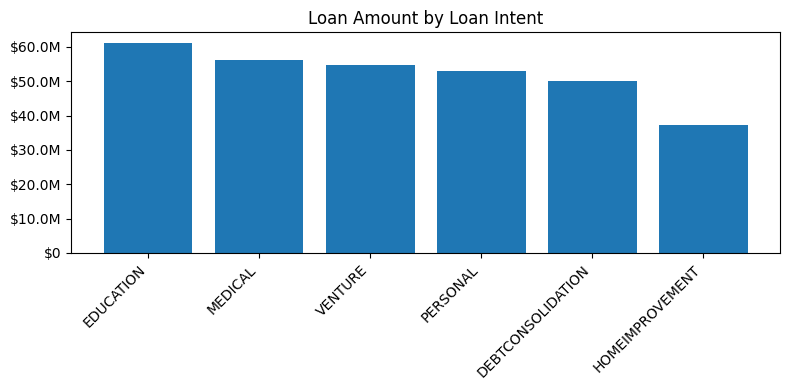

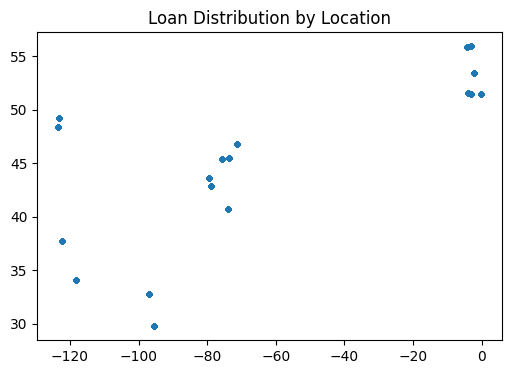

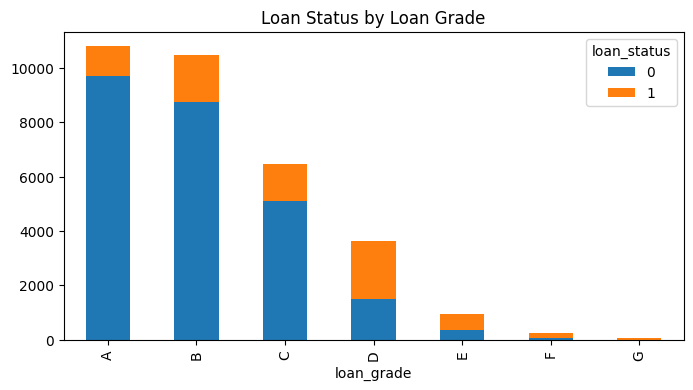

In [47]:
# Visualizations with matplotlib
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
df_viz = pd.read_csv('D:/PY Projects/Credit-Risk/credit_risk_modeling.csv') if os.path.exists('D:/PY Projects/Credit-Risk/credit_risk_modeling.csv') else None

def money(x, pos):
    if x >= 1e6: return f'${x/1e6:.1f}M'
    if x >= 1e3: return f'${x/1e3:.0f}K'
    return f'${x:.0f}'
formatter = FuncFormatter(money)

if df_viz is not None:
    # Cards
    total_customers = df_viz['client_ID'].nunique() if 'client_ID' in df_viz.columns else len(df_viz)
    total_loan_amount = df_viz['loan_amnt'].sum() if 'loan_amnt' in df_viz.columns else 0
    default_rate = (df_viz['loan_status']==0).mean() if 'loan_status' in df_viz.columns else np.nan
    print('Total Customers:', total_customers)
    print('Total Loan Amount:', total_loan_amount)
    print('Default Rate (%):', default_rate*100 if not pd.isnull(default_rate) else None)
    # Clustered column chart
    if 'loan_intent' in df_viz.columns and 'loan_amnt' in df_viz.columns:
        grp = df_viz.groupby('loan_intent')['loan_amnt'].sum().sort_values(ascending=False)
        fig, ax = plt.subplots(figsize=(8,4))
        ax.bar(grp.index.astype(str), grp.values)
        ax.yaxis.set_major_formatter(formatter)
        ax.set_title('Loan Amount by Loan Intent')
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        plt.show()
    # Map scatter
    if 'city_latitude' in df_viz.columns and 'city_longitude' in df_viz.columns:
        fig, ax = plt.subplots(figsize=(6,4))
        ax.scatter(df_viz['city_longitude'], df_viz['city_latitude'], s=10)
        ax.set_title('Loan Distribution by Location')
        plt.show()
    # Stacked column: loan_status by loan_grade
    if 'loan_grade' in df_viz.columns and 'loan_status' in df_viz.columns:
        ct = pd.crosstab(df_viz['loan_grade'], df_viz['loan_status'])
        ct.plot(kind='bar', stacked=True, figsize=(8,4))
        plt.title('Loan Status by Loan Grade')
        plt.show()
else:
    print('Visualization dataframe not available.')

## Section E — Advanced Features (What-if, Drillthrough, RLS)

In [48]:
# Advanced features
df_adv = pd.read_csv('D:/PY Projects/Credit-Risk/credit_risk_modeling.csv') if os.path.exists('D:/PY Projects/Credit-Risk/credit_risk_modeling.csv') else None
if df_adv is not None:
    def simulate_interest_shift(delta_pct):
        rates = df_adv['loan_int_rate'].fillna(df_adv['loan_int_rate'].mean())
        adjusted = rates * (1 + delta_pct)
        payments = df_adv['loan_amnt'] * (1 + adjusted)
        return payments.mean()
    print('What-if examples (avg payment): -2% ->', simulate_interest_shift(-0.02), ' 0% ->', simulate_interest_shift(0.0), ' +2% ->', simulate_interest_shift(0.02))
    def customer_profile(cid):
        row = df_adv[df_adv['client_ID']==cid]
        if row.empty:
            print('client_ID not found')
        else:
            display(row[['client_ID','person_income','loan_amnt','debt_to_income_ratio']].T)
    print('\nExample customer profile for first client:')
    if 'client_ID' in df_adv.columns:
        customer_profile(df_adv['client_ID'].iloc[0])
    def rls_view(types):
        return df_adv[df_adv['employment_type'].isin(types)]
    if 'employment_type' in df_adv.columns:
        print('\nRLS simulation for Full-time only: rows visible ->', len(rls_view(['Full-time'])))
else:
    print('Advanced dataframe not available.')

What-if examples (avg payment): -2% -> 115735.78830658083  0% -> 117902.04171884045  +2% -> 120068.29513110007

Example customer profile for first client:


,0
client_ID,CUST_00001
person_income,59000
loan_amnt,35000
debt_to_income_ratio,0.74



RLS simulation for Full-time only: rows visible -> 19473


## Section F — Final Dashboard & Smart Narrative

Total Loans: 312431300  Approved Loan Amount: 77125375  Default Rate: 0.7818360394094718


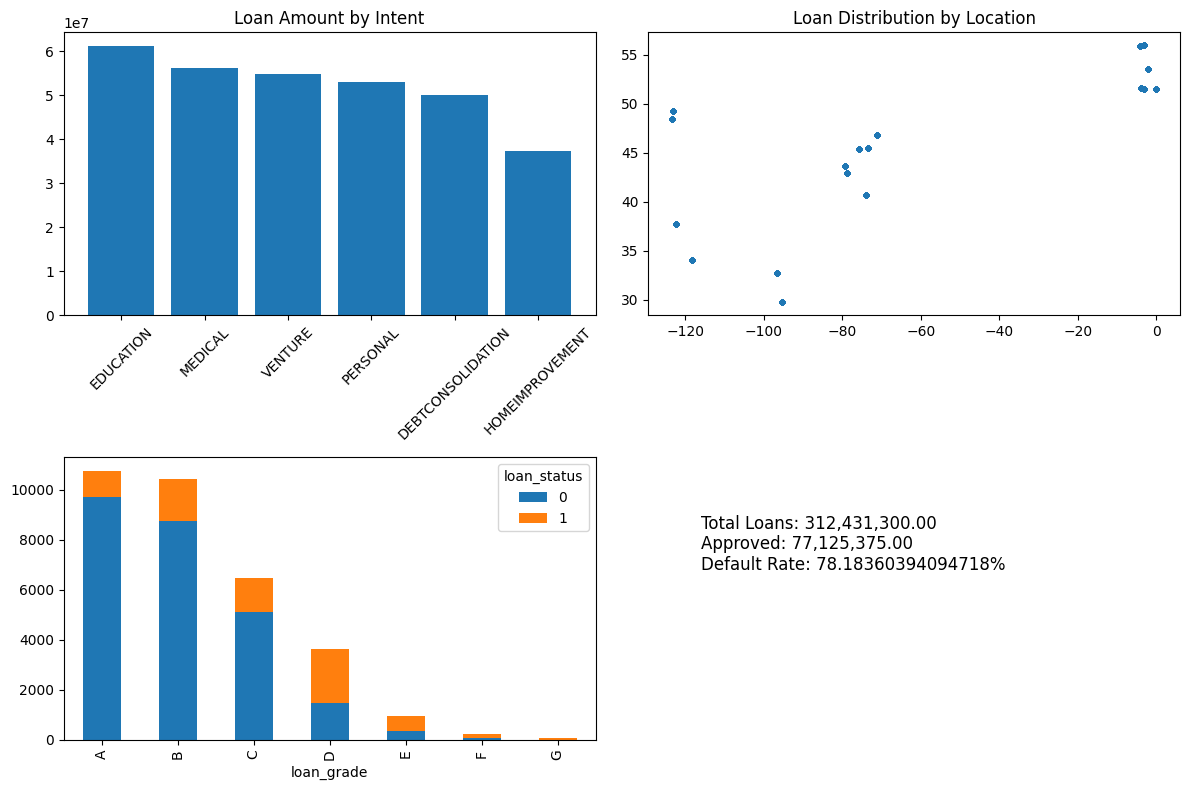


Smart Narrative:
- Highest default rate by intent: VENTURE (85.19%)
- Grade with most defaults: A (9704 defaults)
- Average income for high-risk: 43,929.56


C:\Users\Noman Traders\AppData\Local\Temp\ipykernel_35964\921927782.py:36: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  dr_by_intent = df_dash.groupby('loan_intent').apply(lambda d: (d['loan_status']==0).mean())


In [49]:
# Final dashboard (simple matplotlib layout) and smart narrative
df_dash = pd.read_csv('D:/PY Projects/Credit-Risk/credit_risk_modeling.csv') if os.path.exists('D:/PY Projects/Credit-Risk/credit_risk_modeling.csv') else None
if df_dash is not None:
    total_loans = df_dash['loan_amnt'].sum() if 'loan_amnt' in df_dash.columns else 0
    approved = df_dash.loc[df_dash['loan_status']==1,'loan_amnt'].sum() if 'loan_status' in df_dash.columns else 0
    default_rate = (df_dash['loan_status']==0).mean() if 'loan_status' in df_dash.columns else np.nan
    print('Total Loans:', total_loans, ' Approved Loan Amount:', approved, ' Default Rate:', default_rate)
    fig, axes = plt.subplots(2,2, figsize=(12,8))
    # loan intent bar
    if 'loan_intent' in df_dash.columns and 'loan_amnt' in df_dash.columns:
        grp = df_dash.groupby('loan_intent')['loan_amnt'].sum().sort_values(ascending=False)
        axes[0,0].bar(grp.index.astype(str), grp.values)
        axes[0,0].set_title('Loan Amount by Intent')
        axes[0,0].tick_params(axis='x', rotation=45)
    else:
        axes[0,0].text(0.5,0.5,'No data', ha='center')
    # map
    if 'city_latitude' in df_dash.columns and 'city_longitude' in df_dash.columns:
        axes[0,1].scatter(df_dash['city_longitude'], df_dash['city_latitude'], s=8)
        axes[0,1].set_title('Loan Distribution by Location')
    else:
        axes[0,1].text(0.5,0.5,'No location data', ha='center')
    # stacked grade/status
    if 'loan_grade' in df_dash.columns and 'loan_status' in df_dash.columns:
        ct = pd.crosstab(df_dash['loan_grade'], df_dash['loan_status'])
        ct.plot(kind='bar', stacked=True, ax=axes[1,0])
    else:
        axes[1,0].text(0.5,0.5,'No data', ha='center')
    axes[1,1].axis('off')
    axes[1,1].text(0.1,0.6,f'Total Loans: {total_loans:,.2f}\nApproved: {approved:,.2f}\nDefault Rate: {default_rate*100 if not pd.isnull(default_rate) else "NA"}%', fontsize=12)
    plt.tight_layout()
    plt.show()
    # Smart narrative generation
    insights = []
    if 'loan_intent' in df_dash.columns and 'loan_status' in df_dash.columns:
        dr_by_intent = df_dash.groupby('loan_intent').apply(lambda d: (d['loan_status']==0).mean())
        highest = dr_by_intent.idxmax()
        insights.append(f'Highest default rate by intent: {highest} ({dr_by_intent.max():.2%})')
    if 'loan_grade' in df_dash.columns and 'loan_status' in df_dash.columns:
        defaults = df_dash[df_dash['loan_status']==0]['loan_grade'].value_counts()
        if not defaults.empty:
            insights.append(f'Grade with most defaults: {defaults.idxmax()} ({defaults.max()} defaults)')
    if 'Debt_to_Income_Check' in df_dash.columns and 'person_income' in df_dash.columns:
        hr = df_dash[df_dash['Debt_to_Income_Check']=="High Risk"]
        if not hr.empty:
            insights.append(f'Average income for high-risk: {hr["person_income"].mean():,.2f}')
    print('\nSmart Narrative:')
    for s in insights:
        print('-', s)
else:
    print('Dashboard dataframe not available.')